<a href="https://colab.research.google.com/github/Richa-yadav/LoRA_FineTuning/blob/main/LoRA_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install dependencies

!pip install -q accelerate bitsandbytes trl peft transformers datasets matplotlib pandas

import torch
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel
from trl import SFTTrainer
from huggingface_hub import login
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 34.5 MB/s eta 0:00:00


In [2]:
# 2. Login to Hugging Face

login()

In [3]:
# 3. Load dataset

print("Loading dataset...")
dataset = load_dataset("winglian/pirate-ultrachat-10k", split="train")
dataset = dataset.shuffle(seed=42).select(range(500))  # only 500 for quick run

# Split into train/val
train_test_split = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(eval_dataset)}")


Loading dataset...


train.jsonl:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Training samples: 450, Validation samples: 50


In [4]:
# 4. Tokenizer & formatting

model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

def formatting_func(example):
    chat = example["messages"]
    text = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    return {"text": text}

print("Example formatted input:\n", formatting_func(train_dataset[0])["text"][:300])


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Example formatted input:
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Sep 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What are the benefits of the newly designed high speed pneumatic pressure drive and the continuous conveyor in the skewer ma


In [5]:
# 5. Test base model (before fine-tuning)

print("\n" + "="*60)
print("BASE MODEL RESPONSES")
print("="*60)

base_pipe = pipeline(
    task="text-generation",
    model=model_name,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=50,
    temperature=0.7,
    do_sample=True,
)

test_prompts = [
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What should I do if my ship is stuck in a storm?"}
    ],
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Write me a pirate song about rum and adventure."}
    ]
]

for messages in test_prompts:
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    response = base_pipe(prompt)
    print(f"\nUser: {messages[1]['content']}")
    print(f"Base Model Response: {response[0]['generated_text'][len(prompt):].strip()[:200]}")




BASE MODEL RESPONSES


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0



User: What should I do if my ship is stuck in a storm?
Base Model Response: If your ship is stuck in a storm, it's essential to prioritize your safety and the safety of your crew. Here's a step-by-step guide to help you navigate the situation:

**Stay calm and assess the situ

User: Write me a pirate song about rum and adventure.
Base Model Response: (Verse 1)
Oh, gather 'round me hearties, and listen close to me tale
Of a pirate's life, with rum and adventure that never fails
I set sail on the high seas, with a bottle by me side


In [6]:
# 6. Configure model for LoRA training

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

trainable_params, all_params = model.get_nb_trainable_parameters()
print(f"Trainable parameters: {trainable_params:,} / {all_params:,}")

Trainable parameters: 11,272,192 / 1,247,086,592


In [7]:
# 7. Training setup

output_dir = "./llama-pirate-500"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    num_train_epochs=2,
    logging_steps=5,
    fp16=True,
    gradient_checkpointing=True,
    save_strategy="epoch",
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    formatting_func=formatting_func,
    peft_config=peft_config,
)

Applying formatting function to train dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

In [8]:
# 8. Train

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

trainer.train()

# Explicit save (ensures adapter_config.json is written)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.



STARTING TRAINING


Step,Training Loss
5,2.162000
10,2.202800
15,2.060900
20,2.105000
25,1.873800
30,1.770000
35,1.978100
40,1.855600
45,1.701000
50,1.906600


('./llama-pirate-500/tokenizer_config.json',
 './llama-pirate-500/special_tokens_map.json',
 './llama-pirate-500/chat_template.jinja',
 './llama-pirate-500/tokenizer.json')

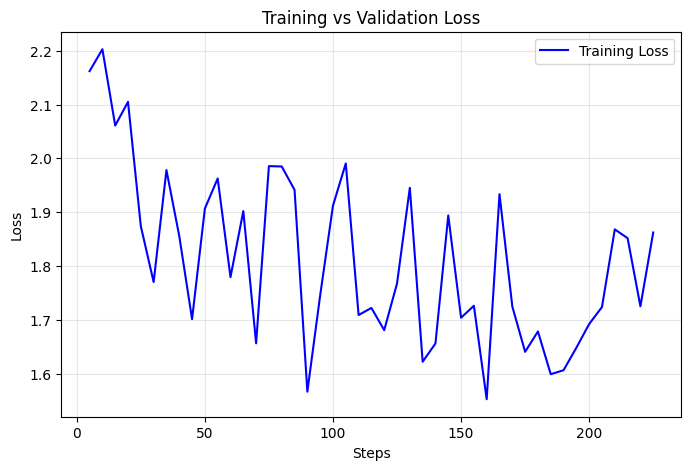

In [9]:
# 9. Loss curves

train_loss, eval_loss, steps, eval_steps = [], [], [], []

for log in trainer.state.log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        steps.append(log.get("step", len(steps)))
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log.get("step", len(eval_steps)))

plt.figure(figsize=(8,5))
if train_loss:
    plt.plot(steps, train_loss, "b-", label="Training Loss")
if eval_loss:
    plt.plot(eval_steps, eval_loss, "r-", label="Validation Loss")
plt.xlabel("Steps"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# 10. Reload fine-tuned model

print("\n" + "="*60)
print("LOADING FINE-TUNED MODEL")
print("="*60)

del model
del trainer
torch.cuda.empty_cache()

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
finetuned_model = PeftModel.from_pretrained(base_model, output_dir)

finetuned_pipe = pipeline(
    task="text-generation",
    model=finetuned_model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True,
)


LOADING FINE-TUNED MODEL


Device set to use cuda:0


In [11]:
# 11. Compare Base vs Fine-tuned

print("\n" + "="*60)
print("BASE vs FINE-TUNED RESPONSES")
print("="*60)

results = []
for messages in test_prompts:
    user_prompt = messages[1]["content"]

    # Base response
    base_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    base_response = base_pipe(base_prompt)[0]["generated_text"][len(base_prompt):].strip()

    # Fine-tuned response
    finetune_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    finetune_response = finetuned_pipe(finetune_prompt)[0]["generated_text"][len(finetune_prompt):].strip()

    results.append({
        "User Prompt": user_prompt,
        "Base Model Response": base_response,
        "Fine-tuned Model Response": finetune_response
    })

df = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
display(df)


BASE vs FINE-TUNED RESPONSES


,User Prompt,Base Model Response,Fine-tuned Model Response
0,What should I do if my ship is stuck in a storm?,"Being stranded in a storm can be a stressful and frightening experience. If your ship is stuck in a storm, follow these steps to ensure your safety:\n\n1. **Stay calm**: Panic can cloud your judgment, so take a few deep breaths and","Ahoy there, matey! A storm, you say? Shiver me timbers! That's no ordinary weather we're talkin' about here, me hearty! You're talkin' about a tempest like a kraken, a real storm that'll leave you walkin' the plank! Don't worry, I've sailed through worse, but I can tell you a thing or two about how to navigate a storm at sea.\n\nFirst, you gotta"
1,Write me a pirate song about rum and adventure.,"(Verse 1)\nOh, I set sail on the Black Dragon's tide\nMe hearty crew and I, we're bound for the other side\nWe've got a bottle o' rum in me pocket and a plan in me head\nWe","Ahoy, matey! Gather 'round and listen close, for I've got a tale to tell of a rum-filled night, full of swashbuckling fun and derring-do. The wind in me hair, the rum in me belly, and the sea spray on me face, it's a pirate's life for me!\n\n(Verse 1)\nOh, the rum flowed like the ocean's tide\nAs we sailed the seven seas, side by side\nWe plunder"
